Epoch 1/30
19/19 [==============================] - 4s 77ms/step - loss: 2.0916 - accuracy: 0.2667 - val_loss: 1.7852 - val_accuracy: 0.3200
Epoch 2/30
19/19 [==============================] - 1s 44ms/step - loss: 1.6999 - accuracy: 0.3567 - val_loss: 1.5940 - val_accuracy: 0.4200
Epoch 3/30
19/19 [==============================] - 1s 44ms/step - loss: 1.4794 - accuracy: 0.4700 - val_loss: 1.4227 - val_accuracy: 0.4700
Epoch 4/30
19/19 [==============================] - 1s 43ms/step - loss: 1.3734 - accuracy: 0.5217 - val_loss: 1.3708 - val_accuracy: 0.4800
Epoch 5/30
19/19 [==============================] - 1s 64ms/step - loss: 1.2703 - accuracy: 0.5200 - val_loss: 1.2756 - val_accuracy: 0.5600
Epoch 6/30
19/19 [==============================] - 1s 55ms/step - loss: 1.1606 - accuracy: 0.5983 - val_loss: 1.1835 - val_accuracy: 0.5950
Epoch 7/30
19/19 [==============================] - 1s 56ms/step - loss: 1.0546 - accuracy: 0.6283 - val_loss: 1.1564 - val_accuracy: 0.5950
Epoch 8/30
19

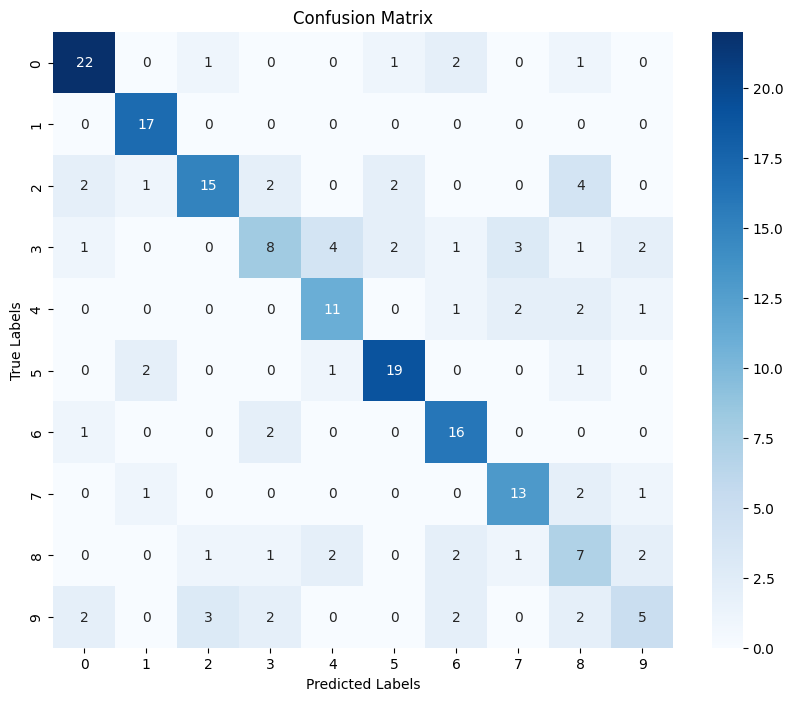

              precision    recall  f1-score   support

       blues       0.79      0.81      0.80        27
   classical       0.81      1.00      0.89        17
     country       0.75      0.58      0.65        26
       disco       0.53      0.36      0.43        22
      hiphop       0.61      0.65      0.63        17
        jazz       0.79      0.83      0.81        23
       metal       0.67      0.84      0.74        19
         pop       0.68      0.76      0.72        17
      reggae       0.35      0.44      0.39        16
        rock       0.45      0.31      0.37        16

    accuracy                           0.67       200
   macro avg       0.64      0.66      0.64       200
weighted avg       0.66      0.67      0.66       200

Accuracy for blues: 0.81
Accuracy for classical: 1.00
Accuracy for country: 0.58
Accuracy for disco: 0.36
Accuracy for hiphop: 0.65
Accuracy for jazz: 0.83
Accuracy for metal: 0.84
Accuracy for pop: 0.76
Accuracy for reggae: 0.44
Accuracy fo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/features_30_sec.csv')

# Separate features and target variable
X = data.drop(['label', 'filename'], axis=1)  # Exclude 'filename'
y = data['label']

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y_one_hot, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# Reshape input for CNN
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_scaled = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Build the CNN model
model = Sequential([
    Conv1D(256, 3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_one_hot.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_data=(X_val_scaled, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
cr = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_)
print(cr)
genre_accuracies = cm.diagonal() / cm.sum(axis=1)
genre_specific_accuracy = dict(zip(label_encoder.classes_, genre_accuracies))
for genre, accuracy in genre_specific_accuracy.items():
    print(f"Accuracy for {genre}: {accuracy:.2f}")

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

model.save('hyperparameter_optimized.h5')

